In [1]:
import itertools

import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import netket as nk

/home/cwpark/acband-laughlin-instability/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


∣NK⟩ Tip: If timeit=True signals high \% spent sampling n_discarded, consider lowering it.

In [2]:
from src.qm_utils.lattice.lattice import Lattice2D
from src.qm_utils.lattice.brillouin_zone import BrillouinZone2D
from src.netket_compat import get_sector_constraints

In [6]:
sqrt3 = np.sqrt(3)
e1 = np.array([1, 0])
e2 = np.array([0, 1])
lB = 1.0
# a_M = 1.0
a_M = (((4 * np.pi) / sqrt3) ** 0.5) * lB
a1 = a_M * e2
a2 = a_M * ((-sqrt3 / 2) * e1 + (1 / 2) * e2)
lattice = Lattice2D(np.stack([a1, a2]))
b = (4 * np.pi) / (a_M * sqrt3)
b1, b2 = lattice.reciprocal_lattice_vectors
b3 = -(b1 + b2)

# N = 27 grid
t1 = (1 / 9) * (b1 - b2)
t2 = (1 / 9) * (b1 - b3)

sample_lattice_27 = Lattice2D(np.stack([t1, t2]))
bz_27 = BrillouinZone2D(lattice, sample_lattice_27)
N_s_27 = bz_27.n_samples
k_points_modified = bz_27.k_points

k_points_modified[26] -= b1
k_points_modified[23] -= b2
k_points_modified[25] += b3
k_points_modified[22] -= b1
k_points_modified[18] -= b2
bz_27.k_points = k_points_modified

# N = 28 grid
p1 = b1 + t2 - t1
normb1 = np.linalg.norm(b1)
normp1 = np.linalg.norm(p1)
distb1p1 = np.linalg.norm(b1 - p1)
scale = normb1 / normp1
rot = -np.arccos((normb1 ** 2 + normp1 ** 2 - distb1p1 ** 2) / (2 * normb1 * normp1))
sample_lattice_28 = sample_lattice_27.transformed(scale=scale, rot=rot)

bz_28 = BrillouinZone2D(lattice, sample_lattice_28)
N_s_28 = bz_28.n_samples

In [7]:
bz_27.n11, bz_27.n12, bz_27.n22, bz_27.n21

(np.int64(3), np.int64(3), np.int64(3), np.int64(-6))

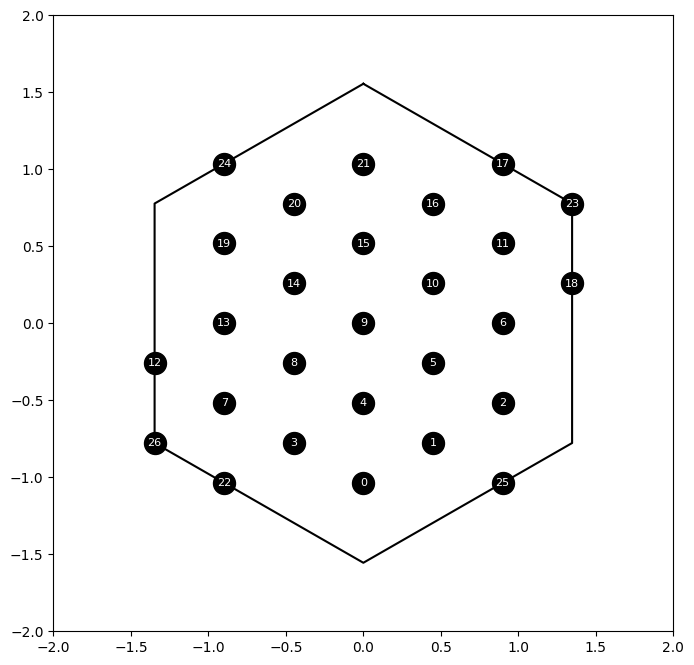

In [8]:
sampled_momentums = bz_27.k_points
R = 3 * np.linalg.norm(t1)
thetas = np.linspace(np.pi / 2, 5 * np.pi / 2, 7)
hexagon_x = R * np.cos(thetas)
hexagon_y = R * np.sin(thetas)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()
k_x = sampled_momentums[:, 0]
k_y = sampled_momentums[:, 1]
ax.scatter(k_x, k_y, s=250, c='k')
for i in range(N_s_27):
    x = k_x[i]
    y = k_y[i]
    ax.text(x, y, f"{i}", fontsize=8, color="w", ha='center', va='center')

ax.plot(hexagon_x, hexagon_y, color='k')

ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
plt.show()

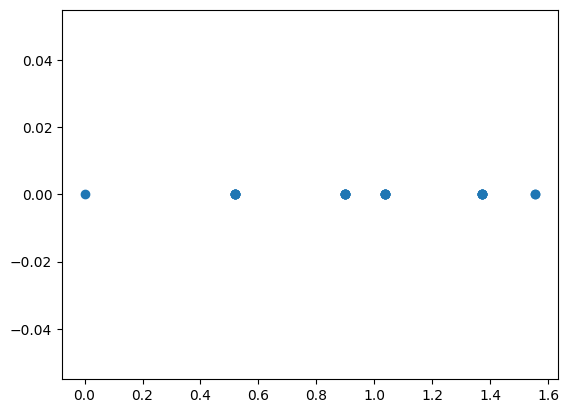

In [41]:
k_norms = []
for k in bz_27.k_points:
    k_norms.append(np.linalg.norm(k))

plt.plot(k_norms, [0] * len(k_norms),'o')

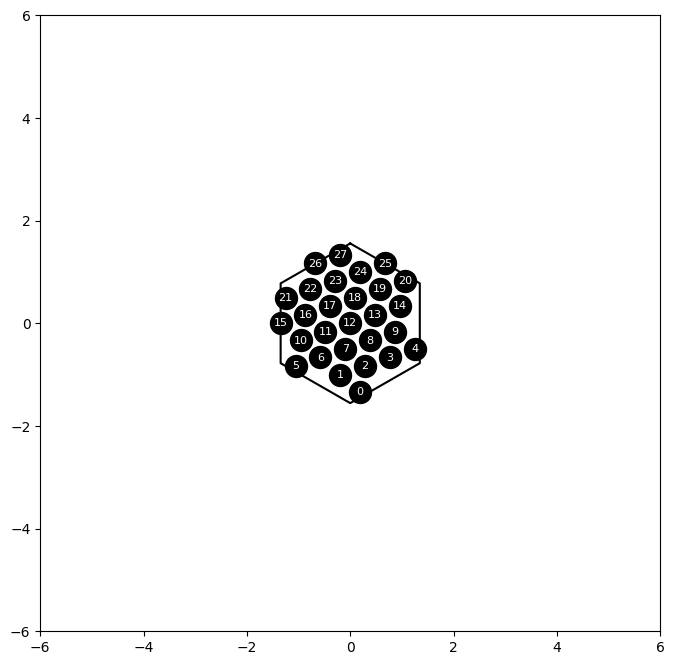

In [42]:
sampled_momentums = bz_28.k_points
R = 3 * np.linalg.norm(t1)
thetas = np.linspace(np.pi / 2, 5 * np.pi / 2, 7)
hexagon_x = R * np.cos(thetas)
hexagon_y = R * np.sin(thetas)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()
k_x = sampled_momentums[:, 0]
k_y = sampled_momentums[:, 1]
ax.scatter(k_x, k_y, s=250, c='k')
for i in range(N_s_28):
    x = k_x[i]
    y = k_y[i]
    ax.text(x, y, f"{i}", fontsize=8, color="w", ha='center', va='center')

ax.plot(hexagon_x, hexagon_y, color='k')

ax.set_xlim(-6, 6)
ax.set_ylim(-6, 6)
plt.show()

bz.n11=np.int64(2), bz.n12=np.int64(4), bz.n21=np.int64(-6), bz.n22=np.int64(2)
28


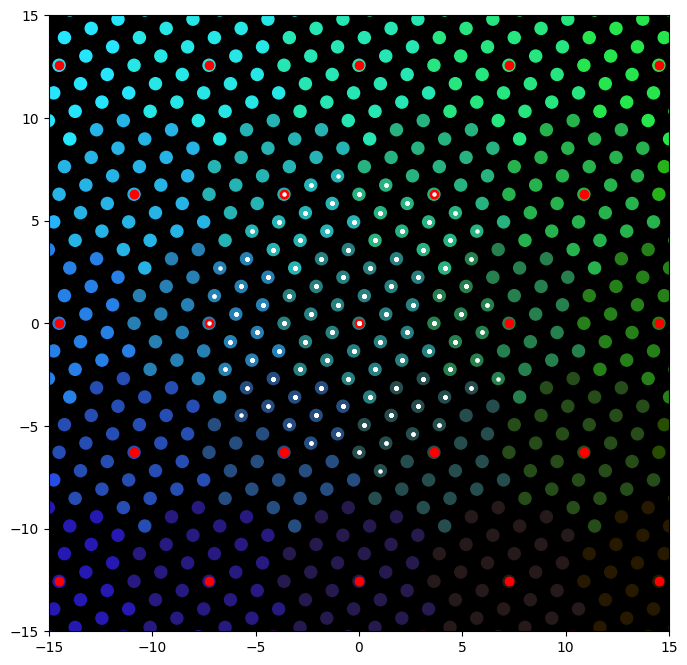

In [43]:
from einops import rearrange

sqrt3 = np.sqrt(3)
e1 = np.array([1, 0])
e2 = np.array([0, 1])
a_M = 1.0
a1 = a_M * e2
a2 = a_M * ((-sqrt3 / 2) * e1 + (1 / 2) * e2)
lattice = Lattice2D(np.stack([a1, a2]))
b = (4 * np.pi) / (a_M * sqrt3)
b1, b2 = lattice.reciprocal_lattice_vectors
b3 = -(b1 + b2)

# N = 27 grid
t1 = (1 / 9) * (b1 - b2)
t2 = (1 / 9) * (b1 - b3)

sample_lattice = Lattice2D(np.stack([t1, t2]))

# N = 28 grid
p1 = b1 + t2 - t1
normb1 = np.linalg.norm(b1)
normp1 = np.linalg.norm(p1)
distb1p1 = np.linalg.norm(b1 - p1)
scale = normb1 / normp1
rot = -np.arccos((normb1 ** 2 + normp1 ** 2 - distb1p1 ** 2) / (2 * normb1 * normp1))
sample_lattice = sample_lattice.transformed(scale=scale, rot=rot)

N = 3
xx = np.linspace(-N, N, 2 * N + 1)
yy = np.linspace(-N, N, 2 * N + 1)
mgrid = np.meshgrid(xx, yy, sparse=True)
points = lattice.reciprocal().get_points(*mgrid, flatten=True)

bz = BrillouinZone2D(lattice, sample_lattice)
print(f"{bz.n11=}, {bz.n12=}, {bz.n21=}, {bz.n22=}")
print(f"{bz.n_samples}")

N = 18
xx = np.linspace(-N, N, 2 * N + 1)
yy = np.linspace(-N, N, 2 * N + 1)
mgrid = np.meshgrid(xx, yy, sparse=True)
samples = sample_lattice.get_points(*mgrid, flatten=True)

lattice_coord, _ = lattice.reciprocal_divmod(samples)
colors = np.zeros((samples.shape[0], 3))
colors[:, 0] = 0.15
colors[:, 1] = 0.5
colors[:, 2] = 0.5

colors += lattice_coord[:, 0][:, None] * np.array([[0, 0.2, 0]])
colors += lattice_coord[:, 1][:, None] * np.array([[0, 0.0, 0.2]])

colors = np.clip(colors, 0.0, 1.0)

bz1 = bz.k_points
bz1_plus_bz1 = rearrange(bz1[:, None, :] + bz1[None, :, :], 'i j d -> (i j) d')

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()
ax.patch.set_facecolor('k')
ax.scatter(samples[:, 0], samples[:, 1], s=75, c=colors)
ax.scatter(points[:, 0], points[:, 1], c='r')
ax.scatter(bz1_plus_bz1[:, 0], bz1_plus_bz1[:, 1], c='w', s=5)
ax.set_xlim(-15, 15)
ax.set_ylim(-15, 15)
plt.show()